In [ ]:
import json
import codecs
import numpy as np
import jieba
from Post_deal import feature_extract, Dimension
import math
import os
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pickle
from sklearn.decomposition import PCA
from tqdm import tqdm


# load label  id_label_dict
weibo_label_file = "/home/lchen/Datasets/weibo/Weibo.txt"
with open(weibo_label_file, "r") as f:
    s = f.readlines()
id_label_dict = {}
for line in s:
    ID_label = [item.split(':')[1] for item in line.split('\t')[:2]]
    id_label_dict[ID_label[0]] = int(ID_label[1])

# load LDA model
with open("LDA_model.pkl","rb") as f:
    lda = pickle.load(f)

# extract feature
path = "/home/lchen/Datasets/weibo/Weibo"
filenames = [os.path.join(path, filename) for filename in os.listdir(path)]
Feature = []
label = []
for filename in tqdm(filenames):
    with open(filename, "r") as f:
        source = json.load(f)[0]
    feature = feature_extract(source)[0].tolist()
    source_text = source['text']    
    doc = list(jieba.cut(source_text))
    doc_bow = lda.id2word.doc2bow(doc)
    doc_lda = [0 for i in range(18)]
    topic_distribute = lda[doc_bow]
    for topic in topic_distribute:
        doc_lda[topic[0]] = topic[1]
    #Feature.append(feature+doc_lda)
    Feature.append(feature)
    label.append(id_label_dict[source["id"]])

Feature = np.asarray(Feature)
label = np.asarray(label)
print("Feature shape:", Feature.shape)
print("label shape:", label.shape)
np.save("Feature_Diffuse.npy", Feature)
np.save("label_Diffuse.npy", label)

In [1]:
import json
import codecs
import numpy as np
import jieba
from Post_deal import feature_extract, Dimension
import math
import os
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pickle
from sklearn.decomposition import PCA
from tqdm import tqdm

def load_label(label_path):  # nonrumor-0 rumor-1
    print("---------- load labels ----------")
    with open(label_path, "r") as f:
        s = f.readlines()
    id_list = [[], []]
    for line in s:
        ID_label = [item.split(':')[1] for item in line.split('\t')[:2]]
        if ID_label[1] == '0':
            id_list[0].append(ID_label[0])
        if ID_label[1] == '1':
            id_list[1].append(ID_label[0])
    return id_list

label_path = "/home/lchen/Datasets/weibo/Weibo.txt"
path = "/home/lchen/Datasets/weibo/Weibo"
id_list = load_label(label_path)
filenames_n = [os.path.join(path, "%s.json"% ID) for ID in id_list[0]]
filenames_r = [os.path.join(path, "%s.json"% ID) for ID in id_list[1]]

# load LDA model
with open("LDA_model.pkl","rb") as f:
    lda = pickle.load(f)

# extract feature
def extract_feature(filenames):
    Feature = []
    for filename in tqdm(filenames):
        with open(filename, "r") as f:
            source = json.load(f)[0]
        feature = feature_extract(source)[0].tolist()
        source_text = source['text']    
        doc = list(jieba.cut(source_text))
        doc_bow = lda.id2word.doc2bow(doc)
        doc_lda = [0 for i in range(18)]
        topic_distribute = lda[doc_bow]
        for topic in topic_distribute:
            doc_lda[topic[0]] = topic[1]
        Feature.append(feature+doc_lda)
    return np.asarray(Feature)

Feature_n = extract_feature(filenames_n)
Feature_r = extract_feature(filenames_r)
#print(Feature_n.shape)

  0%|          | 0/2351 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


---------- load labels ----------


Loading model cost 0.675 seconds.
Prefix dict has been built successfully.
100%|██████████| 2313/2313 [01:20<00:00, 28.63it/s]


In [4]:
Function_origin = ['URL(post[\'text\'])','First_person(post[\'text\'])',
                   'Pos_micro(post_sentiment)','Neg_micro(post_sentiment)']
# Extract features from preprocessed text
Function = ['Len(post[\'text\'])',# Content-based features
            'Positive_words(post[\'text\'])','Negative_words(post[\'text\'])',
            'Sentiment_score(post[\'text\'],emoticons)',
            'Smiling(emoticons) ','Frowning(emoticons)',
            'Hashtags(post[\'text\'])','AT(post[\'text\'])',
            'Q_mark(post[\'text\'])','E_mark(post[\'text\'])',
            'Multi_QE_mark(post[\'text\'])',
            'Person_description(post)', # User-based features
            'Profile(post)','Verified(post)',
            'Verified_type(post)','Friends(post)',
            'Male(post)','City(post)',
            'Follower(post)','Post_count(post)',
            'Exect_days(post)','Reputation_score(post)',
            'Re_post (post)', # Diffusion-based features
            'Comment_count(post)'
            ]
Functions = Function_origin+Function
print(len(Functions))
print(Feature_r.shape)

28
(2313, 46)


/home/lchen/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


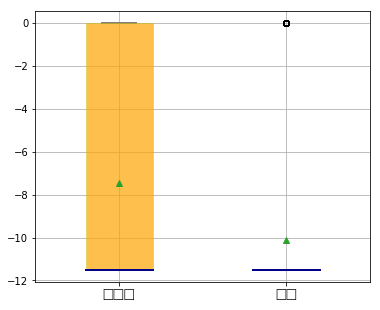

In [7]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

def generate_data(array, num):
    avg = np.mean(array)
    std = np.mean(array)
    return np.random.normal(avg, std*std, num)

font = matplotlib.font_manager.FontProperties(fname="/home/lchen/Documents/Font/Times_New_Roman.ttf")

def box_plot(i, F1, F2):
    #x2 = generate_data(F2[:,i], F1.shape[0])
    #x1 = generate_data(F1[:,i], F1.shape[0])
    x1 = F1[:, i][:F2.shape[0]]
    x2 = F2[:, i]
    x1 = np.log(x1)
    x2 = np.log(x2)
    data = np.vstack((x1, x2))
    #print(data.shape)
    df = pd.DataFrame(data.T, columns=["非谣言","谣言"])    
    plt.figure(figsize =(6,5))
    f = df.boxplot(sym = 'o',
               vert = True, 
               whis = 1.5, 
               patch_artist = True, 
               meanline = False, 
               showmeans = True, 
               showbox = True, showcaps = True, showfliers = True, notch = False, return_type = "dict", widths=0.4
              )
    for box in f['boxes']:
        box.set( color='y', linewidth=0.5)        # 箱体边框颜色
        box.set( facecolor = 'orange' ,alpha=0.7)    # 箱体内部填充颜色
    for whisker in f['whiskers']:
        whisker.set(color='k', linewidth=0.5,linestyle='-')
    for cap in f['caps']:
        cap.set(color='gray', linewidth=2)
    for median in f['medians']:
        median.set(color='DarkBlue', linewidth=2)
    for flier in f['fliers']:
        flier.set(marker='o', color='y', alpha=0.5)
    plt.xticks(fontproperties=font,fontsize=14,color="black")
    # plt.title(Functions[i])
    plt.savefig("./img/log %d %s.png" % (i+1, Functions[i]))
    plt.show()

for i in range(0, 1):
    box_plot(i, Feature_n, Feature_r)